In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

# Table

In [3]:
data_path = "data.05_15_23_39"


def read_json_lines_to_df(file_path):
    df = pd.read_json(open(file_path, "r", encoding="utf8"), lines=True)
    return df


def get_sample_df(data_path=data_path, task="text_summarization"):
    df1 = read_json_lines_to_df(f"{data_path}/{task}.txt")
    df2 = read_json_lines_to_df(f"{data_path}/{task}_result.txt")
    df3 = read_json_lines_to_df(f"{data_path}/{task}_ppl.txt")
    df4 = read_json_lines_to_df(f"{data_path}/{task}_score.txt")
    # merge by id, watermark_process column
    df = pd.merge(df1, df2, on=["id", "watermark_processor"])
    df = pd.merge(df, df3, on=["id", "watermark_processor"])
    # df4 misses some rows, so we use left join
    df = pd.merge(df, df4, on=["id", "watermark_processor"], how="left")
    return df


def get_bootstrap_df(data_path=data_path, task="machine_translation"):
    df1 = read_json_lines_to_df(f"{data_path}/{task}_bleu.txt")
    return df1


def extract_watermark_info(df, return_wp_list=False):
    show_wp = [
        "No Watermark",
        "$\delta$-reweight",
        "$\gamma$-reweight",
        "$\delta$-reweight (woh)",
        "$\gamma$-reweight (woh)",
    ]
    john_wps_set = set()

    def map_wp_str(wp_str):
        if "Delta" in wp_str or "Gamma" in wp_str:
            woh = ", True)" in wp_str
            if "Delta" in wp_str and not woh:
                return show_wp[1]
            elif "Delta" in wp_str and woh:
                return show_wp[3]
            elif "Gamma" in wp_str and not woh:
                return show_wp[2]
            elif "Gamma" in wp_str and woh:
                return show_wp[4]
        elif "John" in wp_str:
            import re

            delta = re.findall(r"delta=(\d+\.?\d*)", wp_str)[0]
            n = "Soft" + f"($\delta$={delta})"
            john_wps_set.add(n)
            return n
        if wp_str == "None":
            return show_wp[0]
        else:
            raise ValueError("Unknown watermark: {}".format(wp_str))

    df = df.assign(show_wp_name=df["watermark_processor"].apply(map_wp_str))
    john_wps = sorted(list(john_wps_set))
    show_wp = show_wp + john_wps
    if return_wp_list:
        return df, show_wp
    else:
        return df


def sample_df_2_stat(df, bootstrap=False, show_wp=None):
    sdf = df.melt(
        id_vars=["show_wp_name"],
        value_vars=[c for c in df.columns if df[c].dtype == np.float64],
        var_name="score",
        value_name="value",
    )
    sdf = sdf.groupby(["show_wp_name", "score"]).agg(["mean", "std", "count"])

    def format_fn(x):
        mean = x["mean"]
        if not bootstrap:
            std = x["std"] / np.sqrt(x["count"])
        else:
            std = x["std"]
        if not np.isfinite(std):
            return f"{mean:.2f}±{std:.2f}"
        useful_digits = np.max(-int(np.floor(np.log10(std / 3))), 0)
        fmt_str = f"{{:.{useful_digits}f}}±{{:.{useful_digits}f}}"
        return fmt_str.format(mean, std)

    sdf = sdf["value"].apply(format_fn, axis=1).unstack()
    if show_wp:
        sdf = sdf.loc[show_wp]
    return sdf


def merge_stat_df(df1, df2):
    df = pd.merge(df1, df2, left_index=True, right_index=True)
    return df

In [4]:
tsdf, show_wp = extract_watermark_info(get_sample_df(), return_wp_list=True)
mtdf = extract_watermark_info(get_sample_df(task="machine_translation"))
mtbsdf = extract_watermark_info(get_bootstrap_df())

In [5]:
sample_df_2_stat(tsdf, show_wp=show_wp)

score,bertscore.f1,bertscore.precision,bertscore.recall,best_dist_q,best_sum_score,ppl,rouge1,rouge2,rougeL
show_wp_name,,,,,,,,,
No Watermark,0.3270±0.0008,0.3180±0.0009,0.3361±0.0010,nan±nan,nan±nan,5.024±0.018,0.3856±0.0009,0.1388±0.0008,0.2445±0.0008
$\delta$-reweight,0.3271±0.0008,0.3180±0.0009,0.3365±0.0010,0.0527±0.0005,67.46±0.23,5.022±0.018,0.3857±0.0009,0.1392±0.0008,0.2451±0.0008
$\gamma$-reweight,0.3269±0.0008,0.3180±0.0009,0.3360±0.0010,0.0289±0.0004,16.87±0.06,5.019±0.018,0.3860±0.0009,0.1397±0.0008,0.2451±0.0008
$\delta$-reweight (woh),0.3276±0.0008,0.3185±0.0009,0.3370±0.0010,0.0100±0.0003,71.86±0.24,5.000±0.018,0.3857±0.0009,0.1398±0.0008,0.2455±0.0008
$\gamma$-reweight (woh),0.3269±0.0008,0.3178±0.0009,0.3361±0.0010,0.00684±0.00024,18.46±0.06,5.010±0.018,0.3856±0.0009,0.1393±0.0008,0.2447±0.0008
Soft($\delta$=0.0),0.3270±0.0008,0.3180±0.0009,0.3361±0.0010,nan±nan,nan±nan,5.024±0.018,0.3856±0.0009,0.1388±0.0008,0.2445±0.0008
Soft($\delta$=1.0),0.3235±0.0008,0.3092±0.0009,0.3382±0.0009,nan±nan,nan±nan,5.313±0.018,0.3820±0.0009,0.1344±0.0007,0.2400±0.0007
Soft($\delta$=2.0),0.3121±0.0008,0.2908±0.0008,0.3339±0.0009,nan±nan,nan±nan,6.253±0.022,0.3717±0.0008,0.1238±0.0007,0.2293±0.0007


In [6]:
merge_stat_df(
    sample_df_2_stat(mtdf, show_wp=show_wp),
    sample_df_2_stat(mtbsdf, bootstrap=True, show_wp=show_wp),
)

score,bertscore.f1,bertscore.precision,bertscore.recall,best_dist_q,best_sum_score,ppl,bleu
show_wp_name,,,,,,,
No Watermark,0.559±0.003,0.545±0.004,0.574±0.003,nan±nan,nan±nan,86±8,21.8±0.3
$\delta$-reweight,0.563±0.003,0.549±0.004,0.577±0.003,0.083±0.004,14.61±0.28,89±13,21.7±0.3
$\gamma$-reweight,0.562±0.003,0.548±0.004,0.576±0.003,0.0570±0.0026,3.68±0.07,91±9,21.8±0.3
$\delta$-reweight (woh),0.569±0.003,0.555±0.003,0.583±0.003,0.0381±0.0029,15.78±0.29,73±4,21.9±0.3
$\gamma$-reweight (woh),0.563±0.003,0.549±0.003,0.577±0.003,0.0280±0.0019,4.17±0.07,81±6,21.8±0.3
Soft($\delta$=0.0),0.559±0.003,0.545±0.004,0.574±0.003,nan±nan,nan±nan,86±8,21.8±0.3
Soft($\delta$=1.0),0.551±0.003,0.536±0.004,0.567±0.004,nan±nan,nan±nan,96±10,21.0±0.3
Soft($\delta$=2.0),0.538±0.003,0.522±0.004,0.554±0.003,nan±nan,nan±nan,98±8,19.5±0.3


# violin diagram

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sample_df(df, score:str, print_name:str, show_wp=None, show_mean=False, violin_kwargs={}):
    sns.violinplot(data=df, x="show_wp_name", y=score, order=show_wp, **violin_kwargs)
    plt.ylabel(print_name)
    plt.xlabel("")
    if show_mean:
        plt.axhline(
            df[df.show_wp_name == "No Watermark"][score].mean(),
            color="red",
            linestyle="--",
            label="Mean performace w/o watermark",
        )
        plt.legend(loc="lower left")
    plt.xticks(rotation=15, ha='center')

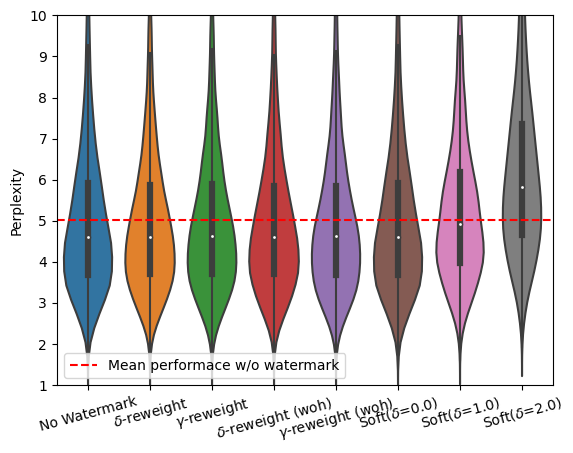

In [8]:
# plot_sample_df(tsdf, "bertscore.f1", "F1", show_wp=show_wp, show_mean=True)
# plt.ylim(0.1, 0.6)
# plot_sample_df(tsdf, "bertscore.precision", "Precision", show_wp=show_wp, show_mean=True)
# plt.ylim(0.1, 0.6)
# plot_sample_df(tsdf, "bertscore.recall", "Recall", show_wp=show_wp, show_mean=True)
# plt.ylim(0.1, 0.6)
# plot_sample_df(tsdf, "rouge1", "ROUGE-1", show_wp=show_wp, show_mean=True)
# plt.ylim(0.15, 0.65)
# plot_sample_df(tsdf, "rouge2", "ROUGE-2", show_wp=show_wp, show_mean=True)
# plt.ylim(0.0, 0.4)
plot_sample_df(tsdf, "ppl", "Perplexity", show_wp=show_wp, show_mean=True)
plt.ylim(1, 10)
plt.show()
# plt.savefig("figures/Violin_TS.pdf", format="pdf")

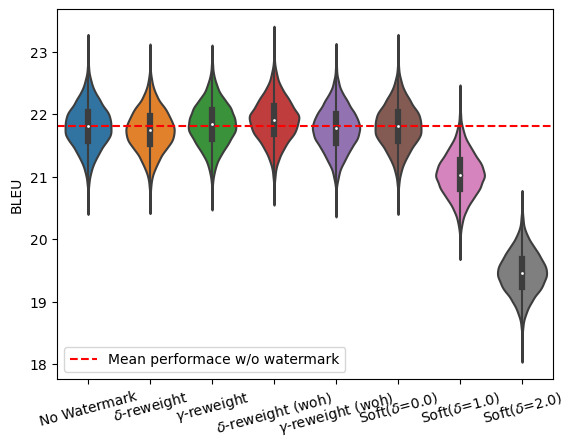

In [9]:
# plot_sample_df(mtdf, "bertscore.f1", "F1", show_wp=show_wp, show_mean=True)
# plt.ylim(0.2, 1.0)
# plot_sample_df(mtdf, "bertscore.precision", "Precision", show_wp=show_wp, show_mean=True)
# plt.ylim(0.1, 1.0)
# plot_sample_df(mtdf, "bertscore.recall", "Recall", show_wp=show_wp, show_mean=True)
# plt.ylim(0.1, 1.0)
plot_sample_df(mtbsdf, "bleu", "BLEU", show_wp=show_wp, show_mean=True)
plt.show()
# plt.savefig("figures/Violin_MT.pdf", format="pdf")

# latex output

In [10]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")

In [11]:
metric_show_name = {
    "bertscore.f1": "BERTScore F1",
    "bertscore.precision": "BERTScore Precision",
    "bertscore.recall": "BERTScore Recall",
    "rouge1": "ROUGE-1",
    "rouge2": "ROUGE-2",
    "rougeL": "ROUGE-L",
    "bleu": "BLEU",
    "ppl": "Perplexity",
}

scaled_columns = [
    "bertscore.f1",
    "bertscore.precision",
    "bertscore.recall",
    "rouge1",
    "rouge2",
    "rougeL",
]


def scale_df(df, scaled_columns=scaled_columns, scale=100):
    df_scaled = df.copy()
    for c in scaled_columns:
        if c in df_scaled.columns:
            df_scaled[c] = df_scaled[c] * scale
    return df_scaled

In [12]:
df1 = sample_df_2_stat(scale_df(tsdf), show_wp=show_wp)[
    ["bertscore.f1", "rouge1", "ppl"]
]
df2 = merge_stat_df(
    sample_df_2_stat(scale_df(mtdf), show_wp=show_wp),
    sample_df_2_stat(mtbsdf, bootstrap=True, show_wp=show_wp),
)[["bertscore.f1", "bleu"]]
print(merge_stat_df(df1, df2).rename(columns=metric_show_name).to_latex())

\begin{tabular}{llllll}
\toprule
score & bertscore.f1\_x &     ROUGE-1 &   Perplexity & bertscore.f1\_y &      BLEU \\
show\_wp\_name            &                &             &              &                &           \\
\midrule
No Watermark            &     32.70±0.08 &  38.56±0.09 &  5.024±0.018 &       55.9±0.3 &  21.8±0.3 \\
\$\textbackslash delta\$-reweight       &     32.71±0.08 &  38.57±0.09 &  5.022±0.018 &       56.3±0.3 &  21.7±0.3 \\
\$\textbackslash gamma\$-reweight       &     32.69±0.08 &  38.60±0.09 &  5.019±0.018 &       56.2±0.3 &  21.8±0.3 \\
\$\textbackslash delta\$-reweight (woh) &     32.76±0.08 &  38.57±0.09 &  5.000±0.018 &       56.9±0.3 &  21.9±0.3 \\
\$\textbackslash gamma\$-reweight (woh) &     32.69±0.08 &  38.56±0.09 &  5.010±0.018 &       56.3±0.3 &  21.8±0.3 \\
Soft(\$\textbackslash delta\$=0.0)      &     32.70±0.08 &  38.56±0.09 &  5.024±0.018 &       55.9±0.3 &  21.8±0.3 \\
Soft(\$\textbackslash delta\$=1.0)      &     32.35±0.08 &  38.20±0.09 &  5.

/tmp/ipykernel_3423308/1244251916.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(merge_stat_df(df1, df2).rename(columns=metric_show_name).to_latex())


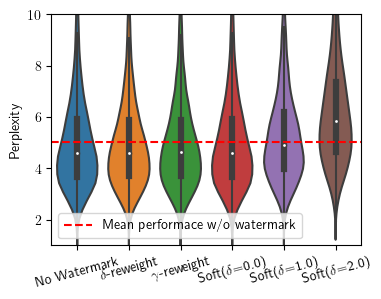

/tmp/ipykernel_3423308/1825298112.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "show_wp" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(


<Figure size 640x480 with 0 Axes>

In [13]:
fig_scale = 1
plt.figure(figsize=(4 * fig_scale, 3 * fig_scale))
plot_sample_df(
    tsdf[~tsdf.show_wp_name.str.contains("woh")],
    "ppl",
    "Perplexity",
    show_wp=filter(lambda x: "woh" not in x, show_wp),
    show_mean=True,
)
plt.ylim(1, 10)
plt.show()
plt.savefig(
    "figures/Violin_TS_PPL.pdf",
    format="pdf",
    show_wp=show_wp,
)

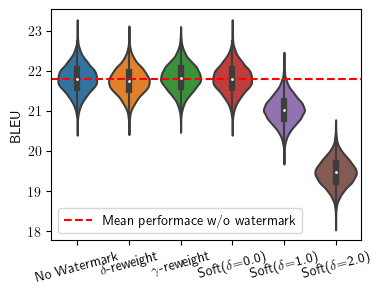

/tmp/ipykernel_3423308/1708277771.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "show_wp" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(


<Figure size 640x480 with 0 Axes>

In [14]:
# plot_sample_df(mtdf, "bertscore.f1", "F1", show_wp=show_wp, show_mean=True)
# plt.ylim(0.2, 1.0)
# plot_sample_df(mtdf, "bertscore.precision", "Precision", show_wp=show_wp, show_mean=True)
# plt.ylim(0.1, 1.0)
# plot_sample_df(mtdf, "bertscore.recall", "Recall", show_wp=show_wp, show_mean=True)
# plt.ylim(0.1, 1.0)

plt.show()
# plt.savefig("figures/Violin_MT.pdf", format="pdf")
fig_scale = 1
plt.figure(figsize=(4 * fig_scale, 3 * fig_scale))
plot_sample_df(
    mtbsdf[~mtbsdf.show_wp_name.str.contains("woh")],
    "bleu",
    "BLEU",
    show_wp=filter(lambda x: "woh" not in x, show_wp),
    show_mean=True,
)
plt.show()
plt.savefig(
    "figures/Violin_MT_BLEU.pdf",
    format="pdf",
    show_wp=show_wp,
)